In [47]:
import numpy as np
import pandas

features = pandas.read_csv('../../data/medical/historical_X.dat', header=None, sep=" ").values
actions = pandas.read_csv('../../data/medical/historical_A.dat', header=None, sep=" ").values
outcome = pandas.read_csv('../../data/medical/historical_Y.dat', header=None, sep=" ").values
observations = features[:, :128]
labels = features[:,128] + features[:,129]*2

In [48]:
# Are some features more predictive of disease symptoms?
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer
import matplotlib.pyplot as plt
%matplotlib inline

clf = LogisticRegression()
clf.fit(observations, labels)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [52]:
from sklearn.ensemble import ExtraTreesClassifier
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0, bootstrap=True)
forest.fit(observations, labels)

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Feature ranking:
1. feature 5 (0.074413)
2. feature 3 (0.051341)
3. feature 113 (0.027742)
4. feature 72 (0.015575)
5. feature 11 (0.015558)
6. feature 83 (0.014207)
7. feature 1 (0.013710)
8. feature 94 (0.013503)
9. feature 55 (0.013465)
10. feature 127 (0.011640)
11. feature 71 (0.011504)
12. feature 108 (0.011497)
13. feature 0 (0.011461)
14. feature 69 (0.011074)
15. feature 66 (0.011044)
16. feature 52 (0.010727)
17. feature 126 (0.010025)
18. feature 51 (0.009928)
19. feature 112 (0.008984)
20. feature 4 (0.008577)
21. feature 122 (0.007931)
22. feature 119 (0.007926)
23. feature 105 (0.007924)
24. feature 87 (0.007667)
25. feature 88 (0.007292)
26. feature 125 (0.007164)
27. feature 9 (0.006982)
28. feature 13 (0.006846)
29. feature 48 (0.006765)
30. feature 89 (0.006613)
31. feature 67 (0.006603)
32. feature 90 (0.006554)
33. feature 109 (0.006542)
34. feature 49 (0.006540)
35. feature 115 (0.006522)
36. feature 111 (0.006522)
37. feature 114 (0.006514)
38. feature 34 (0.00650

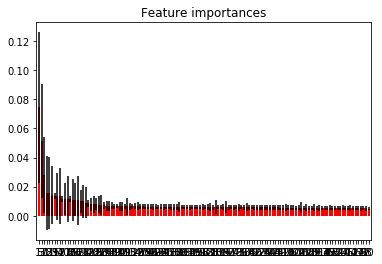

In [55]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(observations.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(observations.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(observations.shape[1]), indices)
plt.xlim([-1, observations.shape[1]])
plt.show()

# Run a (Bayesian?) clustering algorithm

In [56]:
from sklearn import mixture
from sklearn.model_selection import train_test_split

# Since we cannot use the marginal likelihood, we can run train-test splits instead to calculate the likelihood on the test set
[X_train, X_test, y_train, y_test] = train_test_split(observations, labels)

In [58]:
# sadly there is no way to see what the posterior over the components is. The Bayesian model is too much of a black box.
#estimator = mixture.BayesianGaussianMixture(weight_concentration_prior_type="dirichlet_process",
#        n_components=4, n_init=3, max_iter=1000)
# So, we are using a simple GMM instead. I assume that different y values correspond to a different model
for components in range(1,8):
    estimator = mixture.GaussianMixture(n_components=components, n_init=3, max_iter=1000)
    estimator.fit(X_train, y_train)
    score =  estimator.score(X_test, y_test)
    print(components, score)


1 -32.31670986948105
2 -26.869103109522346
3 -22.421317294576937
4 -19.574322002087072
5 -18.190643544866795
6 -14.188253663370928
7 -14.67897555409466


# Discussion of the results
The likelihood on the test data seems to increase with the number of cluster components, even though we know that there are only two clusters. This is probably due to the fact that the underlying distribution is not normal. 

# Use PyMC for Bayesian clustering

In [ ]:
# Try and transform univariate normal into multivariate example -- This is example 1 --
import pymc3 as pm, theano.tensor as tt
# setup model
model = pm.Model()
n_clusters = 2
n_dim = 130
with model:
    # cluster sizes
    p = pm.Dirichlet('p', a=np.ones(n_clusters), shape=n_clusters)
    
    # cluster centers
    cov = np.identity(n_dim)
    mu = np.zeros(n_dim)

    means = pm.MvNormal('means', mu=mu, cov=cov, shape=n_clusters)
    
    # measurement error
    sd = pm.Exponential('sd')
    
    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=ndata)

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=sd,
                       observed=data)


In [ ]:
## This is a different example, let's try and adapt this as well.
# Multivariate example
N_COMPONENTS = 5
N_SAMPLES, N_DIMS = target_data.shape

# Dirichilet prior.
ALPHA_0 = np.ones(N_COMPONENTS)
# Component means prior.
MU_0 = np.zeros(N_DIMS)
LAMB_0 = 2. * np.eye(N_DIMS)
# Components precision prior.
BETA_0, BETA_1 = .1, 2.    # Covariance stds prior uniform limits.
L_0 = 5.       # LKJ corr. shape. Larger shape -> more biased to identity.

# In order to convert the upper triangular correlation values to a
# complete correlation matrix, we need to construct an index matrix:
# Source: http://stackoverflow.com/q/29759789/1901296
N_ELEMS = N_DIMS * (N_DIMS - 1) / 2
tri_index = np.zeros([N_DIMS, N_DIMS], dtype=int)
tri_index[np.triu_indices(N_DIMS, k=1)] = np.arange(N_ELEMS)
tri_index[np.triu_indices(N_DIMS, k=1)[::-1]] = np.arange(N_ELEMS)

with pm.Model() as model:
    # Component weight prior.
    pi = pm.Dirichlet('pi', ALPHA_0, testval=np.ones(N_COMPONENTS) / N_COMPONENTS)
    #pi_potential = pm.Potential('pi_potential', tensor.switch(tensor.min(pi) < .01, -np.inf, 0))

    ###################
    # Components plate.
    ###################
    # Component means.
    mus = [pm.MvNormal('mu_{}'.format(i), MU_0, LAMB_0, shape=N_DIMS)
           for i in range(N_COMPONENTS)]

    # Component precisions.
    #lamb = diag(sigma) * corr(corr_shape) * diag(sigma)
    corr_vecs = [
            pm.LKJCorr('corr_vec_{}'.format(i), L_0, N_DIMS)
            for i in range(N_COMPONENTS)
    ]
    # Transform the correlation vector representations to matrices.
    corrs = [
        tensor.fill_diagonal(corr_vecs[i][tri_index], 1.)
        for i in range(N_COMPONENTS)
    ]
    # Stds for the correlation matrices.
    cov_stds = pm.Uniform('cov_stds', BETA_0, BETA_1, shape=(N_COMPONENTS, N_DIMS))
    # Finally re-compose the covariance matrices using diag(sigma) * corr * diag(sigma)
    # Source http://austinrochford.com/posts/2015-09-16-mvn-pymc3-lkj.html
    lambs = []
    for i in range(N_COMPONENTS):
        std_diag = tensor.diag(cov_stds[i])
        cov = std_diag.dot(corrs[i]).dot(std_diag)
        lambs.append(tensor.nlinalg.matrix_inverse(cov))

    stacked_mus = tensor.stack(mus)
    stacked_lambs = tensor.stack(lambs)

    #####################
    # Observations plate.
    #####################
    z = pm.Categorical('z', pi, shape=N_SAMPLES)

    y = pm.MvNormal('y', stacked_mus[z], stacked_lambs[z], observed=target_data)